# Road Traffic Accidents in Switzerland

In this project, we work with the data from Switzerland's road accidents.

In [1]:
import helpers
from grid_helpers import *
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import requests
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Scraping the data

Writing to the "Office Fédéral des Statistiques" was unsuccessful, so we resort to web scraping.

The scraped data comes from http://map.donneesaccidents.ch/ (or https://map.geo.admin.ch/?topic=vu&lang=fr&bgLayer=ch.swisstopo.pixelkarte-grau&layers=ch.astra.unfaelle-personenschaeden_alle&layers_timestamp=&catalogNodes=1318, after redirections).

![Map](Resources/images/swissaccidentsmap.png)

#### Layers

The map contains the following layers:
* Accidents with personal injury
* Accidents with fatalities
* Accidents involving a pedestrian
* Accidents involving a bicycle
* Accidents involving a motorcycle

There is no information regarding accidents where nobody is unjured, since by law only accidents in which someone is injured require police intervention. This explains why only these are archived.

#### Getting detailed accident data

The map only displays markers for each accident. When one or more markers are selected, a web query retrieves the information related to the selected markers. Using postman, we analysed such queries and found a way to select several or all markers on the map.

This is achieved by defining a rectangle, and querying for all markers inside it. We declare a rectangle that encompasses all Switzerland. This behaviour can be simulated on the browser by holding the ctrl key (or cmd on mac) and dragging a rectangle over the map.
The returned data is paginated, so it is necessary to go over all the pages to obtain all detailed accident data.

Example query parameters:
```
geometry:443999.04209536605,39001.6733318335,870499.0420953662,303001.67333183356
geometryFormat:geojson
geometryType:esriGeometryEnvelope
imageDisplay:1536,759,96
lang:en
layers:all:LAYER_PARAM
offset:200
mapExtent:269999.04209536605,9501.673331833561,1037999.042095366,389001.67333183356
returnGeometry:true
tolerance:5
```

`LAYER_PARAM` can be replaced by the appropriate layer name and `offset` is optional.

In [3]:
# Import raw data from http://map.donneesaccidents.ch/
# Do not run thoses cells if the pickle is already computed
# file info : data/data_raw.pickle, md5: ef2338f1e9e295bd1bf055396dbd1058
#data = helpers.import_data()

In [4]:
#pickle.dump(data, open('data/data_raw.pickle', 'wb'))

In [5]:
#raw_df = pd.DataFrame(data)
#raw_df.sample(5)

## Cleaning the data

In [6]:
data = pickle.load(open('data/data_raw.pickle', 'rb'))

In this initial data dump, we see the following fields:
* **`bbox`** Redundant coordinates to place the accident on the map.
* **`featureId`** Unique ID for an accident.
* **`geometry`**  GeoJSON *geometry* object for the accident. Example:
```
{'coordinates': [[663430.0, 193370.0]], 'type': 'MultiPoint'}
```
* **`geometryType`** GeoJSON type
* **`id`** Redundancy of `featureId`
* **`layerBodId`** Map layers the accident belongs to
* **`layerName`** Layer name
* **`properties`** Accident properties. Example:
```
{'accidentday_de': 'Mittwoch / 12h-13h / Mai 2014',
 'accidentday_fr': 'mercredi / 12h-13h / mai 2014',
 'accidentday_it': 'Mercoledì / 12h-13h / Maggio 2014',
 'accidenttype_de': 'Abbiegeunfall',
 'accidenttype_fr': 'accident en quittant une route',
 'accidenttype_it': 'Incidente nello svoltare',
 'accidenttypecode': 3,
 'accidentyear': 2014,
 'canton': 'BE',
 'fsocommunecode': '0979',
 'label': 'Abbiegeunfall',
 'roadtype_de': 'Nebenstrasse',
 'roadtype_fr': 'route secondaire',
 'roadtype_it': 'Strada secondaria',
 'roadtypecode': 433,
 'severitycategory_de': 'Unfall mit Leichtverletzten',
 'severitycategory_fr': 'accident avec blessés légers',
 'severitycategory_it': 'Incidente con feriti leggeri',
 'severitycategorycode': 'ULV'}
```
* **`type`** Redundancy of `geometryType`

The first step to be able to fully manipulate this data is to flatten it:

In [7]:
flat_data = [helpers.flatten(entry) for entry in data]

In [8]:
accidents_df = pd.DataFrame(flat_data)
accidents_df.columns

Index(['bbox', 'featureId', 'geometryType', 'geometry_coordinates',
       'geometry_type', 'id', 'layerBodId', 'layerName',
       'properties_accidentday_de', 'properties_accidentday_fr',
       'properties_accidentday_it', 'properties_accidenttype_de',
       'properties_accidenttype_fr', 'properties_accidenttype_it',
       'properties_accidenttypecode', 'properties_accidentyear',
       'properties_canton', 'properties_fsocommunecode', 'properties_label',
       'properties_roadtype_de', 'properties_roadtype_fr',
       'properties_roadtype_it', 'properties_roadtypecode',
       'properties_severitycategory_de', 'properties_severitycategory_fr',
       'properties_severitycategory_it', 'properties_severitycategorycode',
       'type'],
      dtype='object')

To clean the data, we start by removing the columns that are irrelevant or redundant, such as:
* **`bbox`** coordinates for the accident are available in the `geometry_coordinates` column.
* **`featureId`** we keep `id`
* **`geometryType` and `type`** Innecessary GeoJSON info
* **`layerBodId`** we keep `layerName`
* **Translations**: all translated fields are only kept in french (english not available).

After removing all 

In [9]:
accidents_df = accidents_df.drop([
    'bbox',
    'featureId',
    'geometryType',
    'type',
    'layerName',
    'properties_accidentday_de',
    'properties_accidentday_it',
    'properties_severitycategory_de',
    'properties_severitycategory_it',
    'properties_severitycategory_fr',
    'properties_roadtype_de',
    'properties_roadtype_it',
    'properties_accidenttype_de',
    'properties_accidenttype_it',
    'properties_accidenttype_fr',
    'properties_roadtype_fr',
    'properties_label',
    'geometry_type'
], axis=1)

# Select one set of coordinates for the accident
accidents_df.geometry_coordinates = accidents_df.geometry_coordinates.apply(lambda x: x[0])

accidents_df = accidents_df.set_index('id')
accidents_df = accidents_df.sort_index()

In [10]:
accidents_df.head(5)

,geometry_coordinates,layerBodId,properties_accidentday_fr,properties_accidenttypecode,properties_accidentyear,properties_canton,properties_fsocommunecode,properties_roadtypecode,properties_severitycategorycode
id,,,,,,,,,
000632B7E4500082E0530A83942743EA,"[647210.0, 177439.0]",ch.astra.unfaelle-personenschaeden_fahrraeder,samedi / 22h-23h / juillet 2014,4,2014,BE,0573,432,USV
000632B7E4500082E0530A83942743EA,"[647210.0, 177439.0]",ch.astra.unfaelle-personenschaeden_alle,samedi / 22h-23h / juillet 2014,4,2014,BE,0573,432,USV
000750DA26760038E0530A8394272B98,"[685704.0, 252693.0]",ch.astra.unfaelle-personenschaeden_alle,jeudi / 16h-17h / juillet 2014,2,2014,ZH,0069,430,ULV
000750DA26760038E0530A8394272B98,"[685704.0, 252693.0]",ch.astra.unfaelle-personenschaeden_alle,jeudi / 16h-17h / juillet 2014,2,2014,ZH,0069,430,ULV
0007F58D137500F0E0530A839427CD36,"[750913.0, 256375.0]",ch.astra.unfaelle-personenschaeden_alle,mardi / 06h-07h / juin 2014,0,2014,SG,3212,432,USV


In [11]:
# Accident layers
accidents_df['withBodilyDamage'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_alle'
accidents_df['involvesBicycles'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_fahrraeder'
accidents_df['involvesMotorcycles'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_motorraeder'
accidents_df['involvesPedestrians'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_fussgaenger'
accidents_df['withFatality'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_getoetete'
accidents_df = accidents_df.drop('layerBodId', axis=1)

# Time properties
weekdays_fr_en = {
    'lundi': '1 Monday',
    'mardi': '2 Tuesday',
    'mercredi': '3 Wednesday',
    'jeudi': '4 Thursday',
    'vendredi': '5 Friday',
    'samedi': '6 Saturday',
    'dimanche': '7 Sunday'
}
accidents_df.properties_accidentday_fr = accidents_df.properties_accidentday_fr.apply(lambda x: str.split(x, '/'))
accidents_df['weekday'] = accidents_df.properties_accidentday_fr.apply(lambda x: weekdays_fr_en[x[0].strip(' ')])
accidents_df['time'] = accidents_df.properties_accidentday_fr.apply(lambda x: x[1].strip(' '))
accidents_df['month'] = accidents_df.properties_accidentday_fr.apply(lambda x: x[2].split()[0])
accidents_df['year'] = accidents_df.properties_accidentyear
accidents_df = accidents_df.drop('properties_accidentday_fr', axis=1)
accidents_df = accidents_df.drop('properties_accidentyear', axis=1)
months_fr_en = {
    'janvier': '01 January',
    'février': '02 February',
    'mars': '03 March',
    'avril': '04 April',
    'mai': '05 May',
    'juin': '06 June',
    'juillet': '07 July',
    'août': '08 August',
    'septembre': '09 September',
    'octobre': '10 October',
    'novembre': '11 November',
    'décembre': '12 December'
}
accidents_df.month = accidents_df.month.apply(lambda x: months_fr_en[x])

# Accident severity
severity_codes = {
    'ULV': 'light injuries',
    'USV': 'heavy injuries',
    'UGT': 'deceased'
}
accidents_df.properties_severitycategorycode = accidents_df.properties_severitycategorycode.apply(lambda x: severity_codes[x])

# Accident type
type_of_accident = {
    0: 'Skidding or control loss',
    1: 'Overtaking or changing roads',
    2: 'Collision',
    3: 'Leaving a road',
    4: "Joining a road",
    5: 'Crossing a road',
    6: 'Frontal collision',
    7: 'Parking accident',
    8: 'With pedestrians',
    9: 'With animals',
    99: 'Other'
}
accidents_df.properties_accidenttypecode = accidents_df.properties_accidenttypecode.apply(lambda x: type_of_accident[x])

# Road type
road_type = {
    433: 'Secondary road',
    432: 'Primary road',
    431: 'Fast road',
    430: 'Motorway',
    439: 'Other',
    434: 'Accessory road'
}
accidents_df.properties_roadtypecode = accidents_df.properties_roadtypecode.apply(lambda x: road_type[x])

print('Total accident entries:', len(accidents_df))
accidents_df.sample(5)

Total accident entries: 141461


,geometry_coordinates,properties_accidenttypecode,properties_canton,properties_fsocommunecode,properties_roadtypecode,properties_severitycategorycode,withBodilyDamage,involvesBicycles,involvesMotorcycles,involvesPedestrians,withFatality,weekday,time,month,year
id,,,,,,,,,,,,,,,
C84FF4C92C670140E0430A839427477D,"[685668.0, 253105.0]",Skidding or control loss,ZH,0066,Motorway,light injuries,True,False,False,False,False,7 Sunday,19h-20h,07 July,2012
E794ADDED3BE0112E0430A8394277757,"[717960.0, 137566.0]",Overtaking or changing roads,TI,5281,Primary road,heavy injuries,True,False,False,False,False,6 Saturday,10h-11h,09 September,2013
DD71958BBDC90146E0430A839427ADB0,"[583782.0, 221588.0]",Leaving a road,BE,0372,Primary road,light injuries,False,False,True,False,False,4 Thursday,07h-08h,05 May,2013
D01FBB34BFF7002AE0430A8394271291,"[540721.0, 157820.0]",Skidding or control loss,VD,5586,Other,heavy injuries,True,False,False,False,False,1 Monday,12h-13h,09 September,2012
094E8A71C4D5011EE0530A839427216F,"[594072.0, 195988.0]",Frontal collision,BE,0355,Secondary road,light injuries,False,True,False,False,False,4 Thursday,19h-20h,09 September,2014


Many accidents appear in several layers of the map with different attributes.
We group all these accidents to avoid duplicates and we make sure not to loose any information associated to the incidents.

Most data is exactly the same among duplicates except the information in columns that tell if the accident produced bodily damage, involved pedestrians, bicycles or motorcycles and if the accident had one or more fatalities.

In [12]:
accidents_df = accidents_df.groupby(by=accidents_df.index).agg({
    'geometry_coordinates': 'first',
    'properties_accidenttypecode': 'first',
    'properties_canton': 'first',
    'properties_fsocommunecode': 'first',
    'properties_roadtypecode': 'first',
    'properties_severitycategorycode': 'first',
    'withBodilyDamage': np.max,
    'involvesBicycles': np.max,
    'involvesMotorcycles': np.max,
    'involvesPedestrians': np.max,
    'withFatality': np.max,
    'weekday': 'first',
    'time': 'first',
    'month': 'first',
    'year': 'first'
})

print('There are', len(accidents_df), 'accidents')

There are 74441 accidents


All fields look good except ```time```, which has 2 unwanted values

In [13]:
print('All values : ', sorted(set(accidents_df['time'].values)), '\n')
accidents_df['time'].replace(to_replace=['ERROR!!!', 'inconnu'], value='unknown', inplace=True, method='pad')

nb_replaced = len(accidents_df[accidents_df['time'] == 'unknown'])
print(nb_replaced, 'values replaced with \'unknown\', {0}% of all entries'.format("%.3f" %(nb_replaced/len(accidents_df))))

All values :  ['00h-01h', '01h-02h', '02h-03h', '03h-04h', '04h-05h', '05h-06h', '06h-07h', '07h-08h', '08h-09h', '09h-10h', '10h-11h', '11h-12h', '12h-13h', '13h-14h', '14h-15h', '15h-16h', '16h-17h', '17h-18h', '18h-19h', '19h-20h', '20h-21h', '21h-22h', '22h-23h', '23h-00h', 'ERROR!!!', 'inconnu'] 

561 values replaced with 'unknown', 0.008% of all entries


In [14]:
categorical_columns = list(accidents_df.columns)
categorical_columns.remove('geometry_coordinates')
for col in categorical_columns:
    accidents_df[col] = accidents_df[col].astype('category')

In [15]:
accidents_df.to_csv('data/accidents.csv')

## Transforming the coordinates

The coordinate system used in this dataset is the swiss coordinate system, which doesn't play well with most software.
Thus, we using the formulas described by *U. Marti, 1999* (based on Bollinger, 1967) we convert the accident coordinates from the Swiss projection coordinates to WGS84 coordinate system.

In [16]:
def ch1903_to_wgs84(east, north):
    # Convert origin, where Bern is 0,0
    east -= 600000
    north -= 200000
    east /= 1000000
    north /= 1000000
    # Calculate longitude and latitude in 10000" units
    lon = 2.6779094
    lon += 4.728982 * east
    lon += 0.791484 * east * north
    lon += 0.1306 * east * north * north
    lon -= 0.0436 * east * east * east
    lat = 16.9023892
    lat += 3.238272 * north;
    lat -= 0.270978 * east * east
    lat -= 0.002528 * north * north
    lat -= 0.0447 * east * east * north
    lat -= 0.0140 * north * north * north
    # Convert longitude and latitude back in degrees.
    lon *= 100 / 36
    lat *= 100 / 36
    return [lat, lon]

In [17]:
accidents_df['wgs84_coordinates'] = accidents_df.geometry_coordinates.apply(lambda x: ch1903_to_wgs84(*x))

In [18]:
accidents_df.sample(5)

,geometry_coordinates,time,year,weekday,properties_roadtypecode,withBodilyDamage,involvesMotorcycles,involvesPedestrians,properties_accidenttypecode,properties_canton,properties_fsocommunecode,month,properties_severitycategorycode,involvesBicycles,withFatality,wgs84_coordinates
id,,,,,,,,,,,,,,,,
2A241149C289015CE0530A8394277A94,"[534412.0, 152524.0]",19h-20h,2015,3 Wednesday,Primary road,True,False,True,With pedestrians,VD,5635,10 October,light injuries,False,False,"[46.52080066243824, 6.583895806104293]"
A2493B19AFE03098E0430A865E333098,"[666170.0, 211772.0]",12h-13h,2011,4 Thursday,Other,True,False,False,Skidding or control loss,LU,1061,04 April,light injuries,True,False,"[47.053669422450035, 8.309531204476869]"
1E360CA3D2640106E0530A839427838F,"[732006.0, 276588.0]",12h-13h,2015,3 Wednesday,Secondary road,False,True,False,Leaving a road,TG,4683,08 August,light injuries,False,False,"[47.626664588513336, 9.194906093272488]"
FEDA0107AE7900E2E0430A83942711A1,"[597590.0, 198988.0]",unknown,2014,5 Friday,Motorway,True,False,False,Collision,BE,0351,07 July,light injuries,False,False,"[46.94197359043579, 7.40698467787251]"
C474069CE4AF00FEE0430A839427FB8A,"[656553.0, 272442.0]",11h-12h,2012,6 Saturday,Other,True,False,False,Skidding or control loss,AG,4311,08 August,light injuries,True,False,"[47.60022361610251, 8.190613761746475]"


## Exploring the data

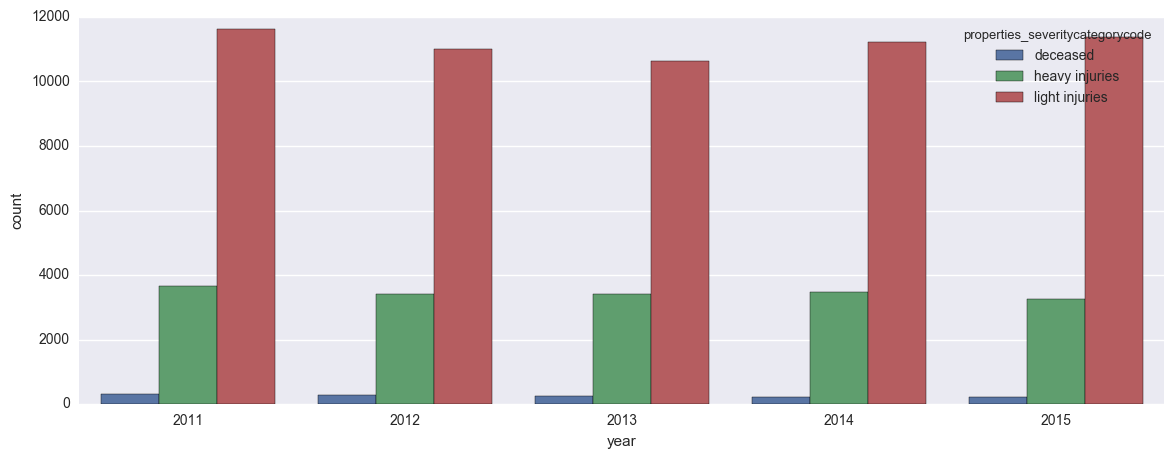

In [19]:
plt.figure(figsize=(14, 5))
sns.countplot(x='year', hue='properties_severitycategorycode', data=accidents_df)

We observe no big variations in accidents in the last 5 years.

In [20]:
accidents_df.year.value_counts(), accidents_df.year.value_counts().mean()

(2011    15597
 2014    14933
 2015    14896
 2012    14722
 2013    14293
 Name: year, dtype: int64, 14888.2)

Average number of accidents over 5 years : 3602.8


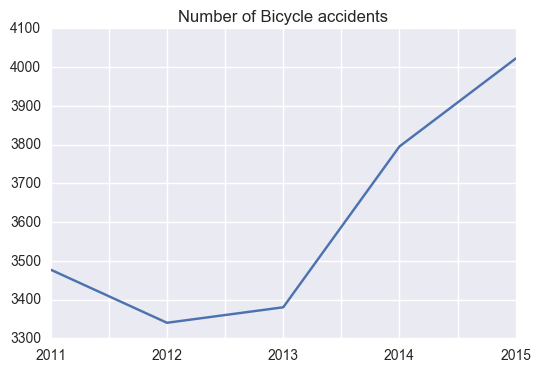

In [21]:
# Bicycle accidents
print('Average number of accidents over 5 years :', accidents_df[accidents_df.involvesBicycles == True].year.value_counts().mean())
accidents_df[accidents_df.involvesBicycles == True].year.value_counts().sort_index().plot(title='Number of Bicycle accidents')

We observe that the number of Bicycle accidents has strongly increased since 2013

Average number of accidents over 5 years : 3915.8


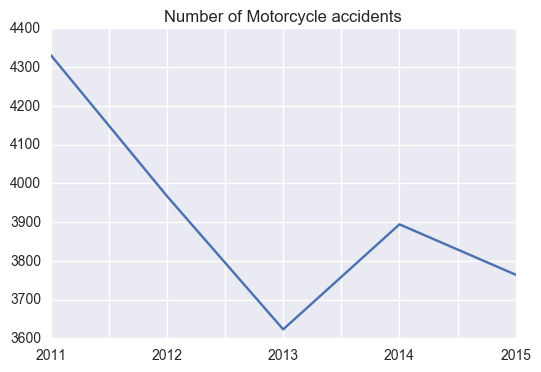

In [22]:
# Motorcycle accidents
print('Average number of accidents over 5 years :', accidents_df[accidents_df.involvesMotorcycles == True].year.value_counts().mean())
accidents_df[accidents_df.involvesMotorcycles == True].year.value_counts().sort_index().plot(title='Number of Motorcycle accidents')

Average number of accidents over 5 years : 2336.0


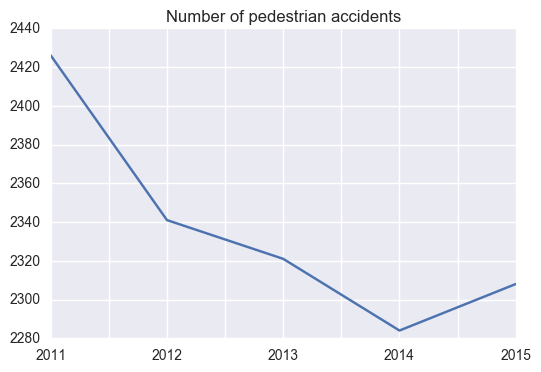

In [23]:
# Pedestrian accidents
print('Average number of accidents over 5 years :', accidents_df[accidents_df.involvesPedestrians == True].year.value_counts().mean())
accidents_df[accidents_df.involvesPedestrians == True].year.value_counts().sort_index().plot(title='Number of pedestrian accidents')

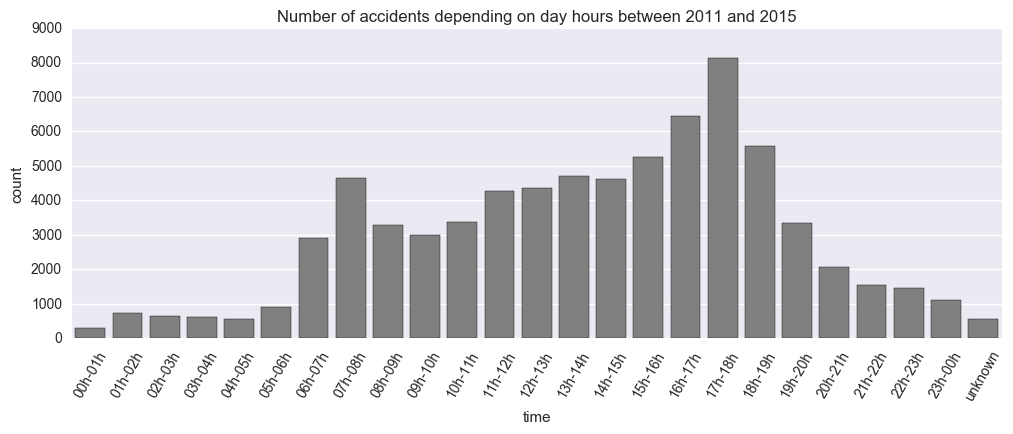

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
g = sns.countplot(x='time', data=accidents_df, color='grey')
g.set_xticklabels(g.get_xticklabels(), rotation=60)
plt.title('Number of accidents depending on day hours between 2011 and 2015')
plt.show()

This plot shows that peak of accidents is located around 5-6pm, which makes sense since it's the time of day during which the traffic is the most dense.

Accidents distribution over the whole set of data (2011-2015) : Hour of day

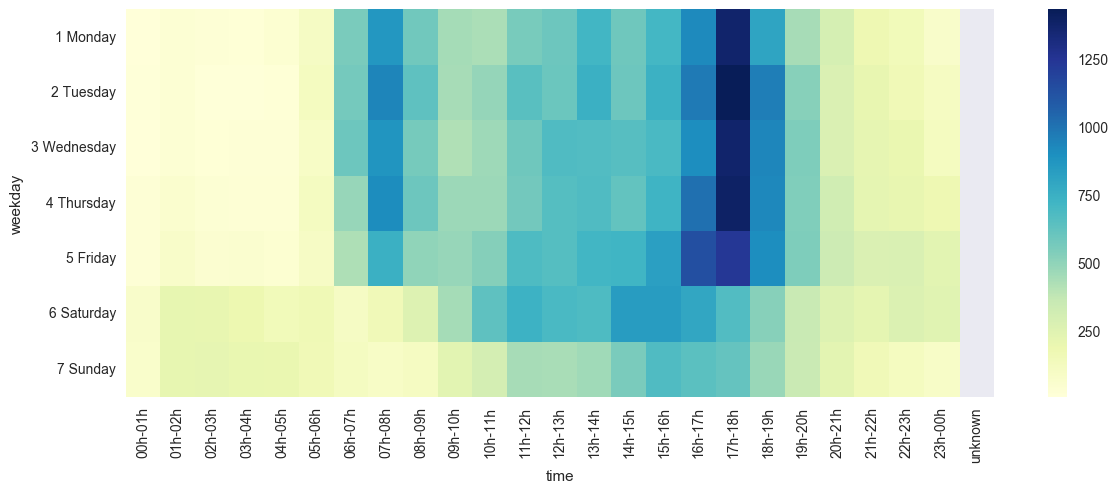

In [25]:
plt.figure(figsize=(14, 5))
time_aware_accidents_df = accidents_df[(accidents_df.time != 'unknown')]
time_aware_accidents_df = time_aware_accidents_df[['time', 'weekday']]
time_aware_accidents_df = time_aware_accidents_df.reset_index()
time_aware_accidents_df = time_aware_accidents_df.groupby(('weekday', 'time')).count().reset_index()
time_aware_accidents_df = time_aware_accidents_df.pivot('weekday', 'time', 'id')
sns.heatmap(time_aware_accidents_df, cmap="YlGnBu")

This heatmap confirms the results of the previous plots, as most accidents occur between 5pm and 6pm, only during weekdays, as the density of traffic at that time is due to the end of workdays.

Accidents distribution over the whole set of data (2011-2015) : Day of month

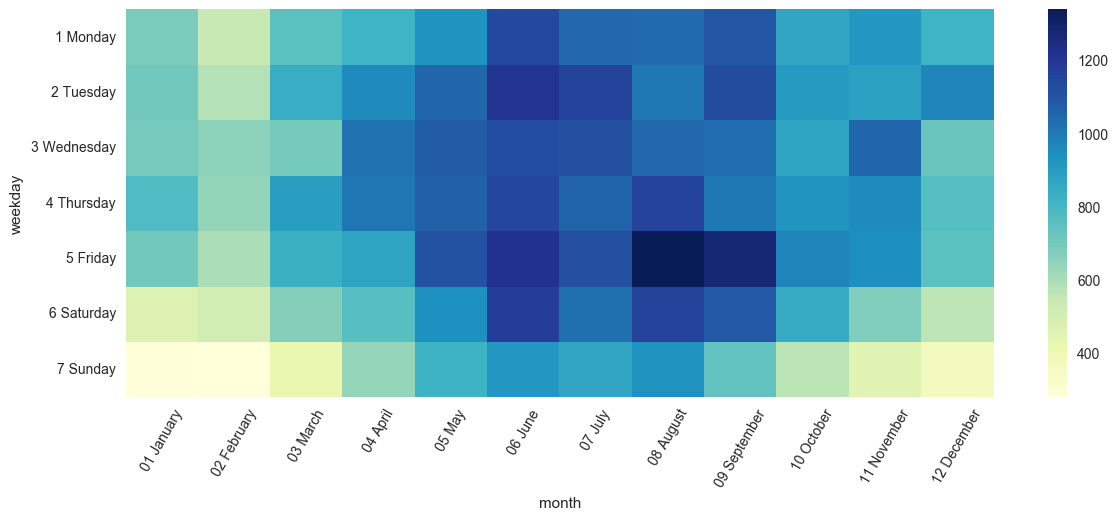

In [26]:
plt.figure(figsize=(14, 5))
time_aware_accidents_df = accidents_df[(accidents_df.time != 'unknown')]
time_aware_accidents_df = time_aware_accidents_df[['month', 'weekday']]
time_aware_accidents_df = time_aware_accidents_df.reset_index()
time_aware_accidents_df = time_aware_accidents_df.groupby(('weekday', 'month')).count().reset_index()
time_aware_accidents_df = time_aware_accidents_df.pivot('weekday', 'month', 'id')
g = sns.heatmap(time_aware_accidents_df, cmap="YlGnBu")
g.set_xticklabels(g.get_xticklabels(), rotation=60)
plt.show()

This heatmap contradicts our initial beliefs. We assumed at first that there would be more accidents during the winter season, but the data shows us that the most dense period of the year in terms of accidents is the summer season.

Accidents distribution over the whole set of data (2011-2015) : Month

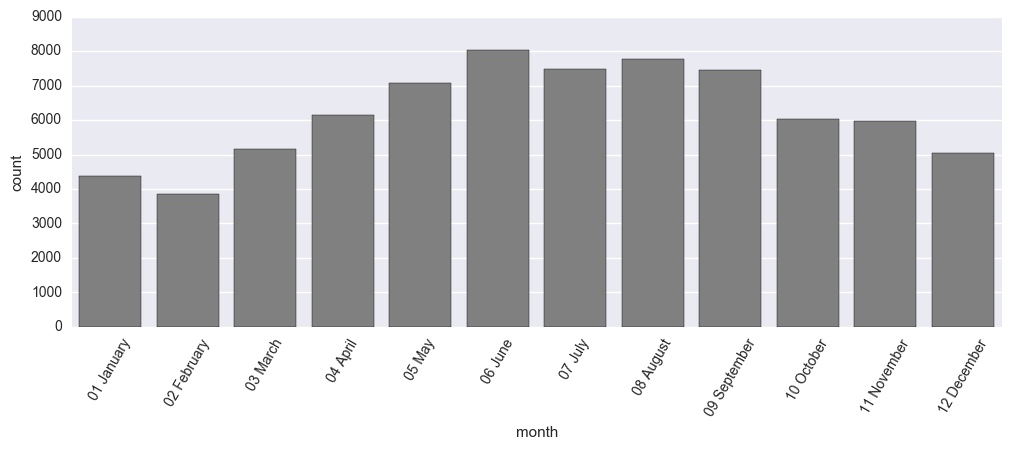

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
g = sns.countplot(x='month', data=accidents_df, color='grey')
g.set_xticklabels(g.get_xticklabels(), rotation=60)
plt.show()

Accidents distribution over the whole set of data (2011-2015) : Road type per day of week

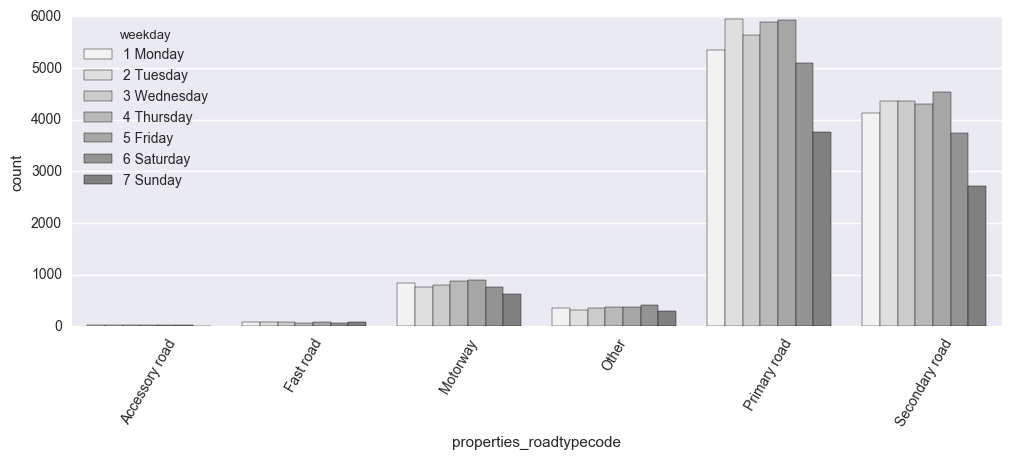

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
g = sns.countplot(x='properties_roadtypecode', hue='weekday', data=accidents_df, color='grey')
g.set_xticklabels(g.get_xticklabels(), rotation=60)
plt.show()

# Comments

# Vizualisation

This heatmap shows the accidents density (all accidents type).

Clicking on the top right button allows the user to select the year(s) to display

In [29]:
accidents_df.to_json('data/accidents.json', orient='index')

In [30]:
%%html
<iframe src="heatmap.html" width="1000px" height="600px"></iframe>

## Grid

Our idea is to create squares all over the swiss map to create areas and then count the accident per area.

Swiss coordinates system is designed so that no two x and y coordinates can be mixed, 1 unit is one meter on the field.

min coord Y : 480000, 070000 (bottom left)
max coord X : 840000, 300000 (top right)

There are squares that are outside Switzerland, but we are not interested in areas with 0 value (as if there are no roads, there cannot be any accident either).

In [53]:
goejson_highest_variance_areas(accidents_df)